In [1]:
import math
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
from my_ecog_utils import read_with_annotations, get_raw_power_bands
from auto_artifact import auto_artifact_from_annot

In [14]:
pts_w_control_and_stim = [103, 106, 109, 110, 111, 112, 113, 115]
pts_w_L_Hip = [109, 110, 111, 112, 113, 115]

In [79]:
mne.set_log_level('WARNING')
raw_recordings_sham = []
for pt_num in pts_w_L_Hip:
    raw = read_with_annotations(pt_num, 'control')
    raw.load_data()
    raw.notch_filter(62.5)

    if pt_num == 100:
        raw.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    if pt_num == 103:
        raw.rename_channels(lambda s: 'L' + s)
    elif pt_num == 108:
        raw.rename_channels(lambda s: s.replace('HIP', 'Hip'))
    elif pt_num == 113:
        raw.rename_channels(lambda s: s.replace('H', 'Hip'))

    raw.pick(['LHip1 - LHip2', 'LHip3 - LHip4'])
    raw_recordings_sham.append(raw)

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)
c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


In [80]:
mne.set_log_level('WARNING')
raw_recordings_stim = []
for pt_num in pts_w_L_Hip:
    raw = read_with_annotations(pt_num, 'stimulated')
    raw.load_data()
    raw.notch_filter(62.5)

    if pt_num == 100:
        raw.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    if pt_num == 103:
        raw.rename_channels(lambda s: 'L' + s)
    elif pt_num == 108:
        raw.rename_channels(lambda s: s.replace('HIP', 'Hip'))
    elif pt_num == 113:
        raw.rename_channels(lambda s: s.replace('H', 'Hip'))

    raw.pick(['LHip1 - LHip2', 'LHip3 - LHip4'])
    raw_recordings_stim.append(raw)

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


In [115]:
peak_freqs = []
for i in range(len(raw_recordings_sham)):
    raw_sham = raw_recordings_sham[i]
    raw_stim = raw_recordings_stim[i]
    psds_sham, freqs_sham = mne.time_frequency.psd_array_welch(raw_sham.get_data(), raw_sham.info['sfreq'])
    psds_stim, freqs_stim = mne.time_frequency.psd_array_welch(raw_stim.get_data(), raw_stim.info['sfreq'])
    assert (freqs_sham == freqs_stim).all()
    for chan in range(2):
        psd_chan = np.abs(psds_stim[chan] - psds_sham[chan])
        idx, mag = mne.preprocessing.peak_finder(psd_chan, (psd_chan.max() - psd_chan.min()) / 5000)
        peak_freqs.append(freqs_sham[idx])

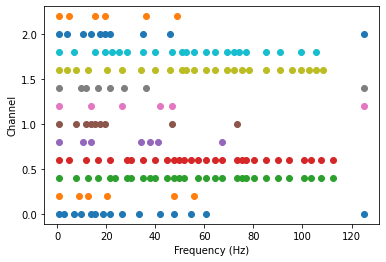

In [114]:
fig, ax = plt.subplots()
for i in range(len(peak_freqs)):
    ax.scatter(*[*zip(*[(freq, 0.2*i) for freq in peak_freqs[i]])])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Channel')

In [116]:
peak_counts = dict()
for band_start in np.arange(0, 125, 0.5):
    chans_in_band = 0
    for chan_peaks in peak_freqs:
        for chan_peak in chan_peaks:
            if chan_peak >= band_start + 5.0:
                break
            if chan_peak >= band_start:
                chans_in_band += 1
                break
            # other option is that chan_peak is less than band_start, in which case, don't do anything
    peak_counts[band_start] = chans_in_band

In [117]:
reverse_sorted_freqs = sorted(peak_counts, key=peak_counts.get)
reverse_sorted_freqs.reverse()

In [120]:
peaks_to_use = []
for freq in reverse_sorted_freqs:
    should_add = True
    for existing_freq in peaks_to_use:
        if abs(freq - existing_freq) < 5.0:
            should_add = False
    
    if should_add:
        peaks_to_use.append(freq)

for freq in peaks_to_use:
    print(freq, peak_counts[freq])

12.5 12
0.5 12
45.5 10
19.5 10
33.0 9
7.5 9
40.0 7
26.0 7
54.5 6
73.0 5
67.0 5
60.5 5
124.5 4
105.0 4
99.5 4
90.5 4
84.5 4
78.0 3
112.0 2
119.5 0


In [124]:
# Winners
peaks_to_use[:6], sorted(peaks_to_use[:6])

([12.5, 0.5, 45.5, 19.5, 33.0, 7.5], [0.5, 7.5, 12.5, 19.5, 33.0, 45.5])